<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SemiSuperVisedLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !pfad angepasst wegen neuem account!
data = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['bands']
labels = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['lulc']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

test = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/public_test.npz')['bands']

In [5]:
# parameters

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# training iterations
ITERS = 1000

# random seed
SEED = 42

# use gpu
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

In [6]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

In [7]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

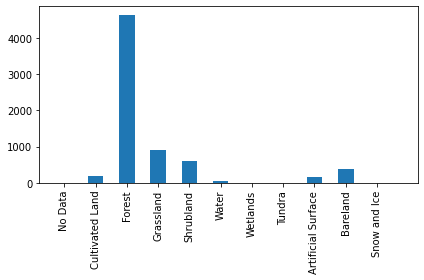

In [8]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [9]:
!pip install catboost
from catboost import CatBoostClassifier

In [10]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)
cbm.fit(x_train, y_train)

In [11]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 98.90694664173738
F1-Score: [ 99.73614776  99.27163668  98.1512605   96.56328583 100.
  97.36070381 100.        ]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       190
           2       0.99      1.00      0.99      4637
           3       0.99      0.97      0.98       900
           4       1.00      0.94      0.97       616
           5       1.00      1.00      1.00        46
           8       0.99      0.95      0.97       174
           9       1.00      1.00      1.00       390

    accuracy                           0.99      6953
   macro avg       1.00      0.98      0.99      6953
weighted avg       0.99      0.99      0.99      6953



Validation

Accuracy: 83.66877515813687
F1-Score: [62.79069767 92.72503083 68.20276498 41.15226337 66.66666667 63.88888889
 76.04166667]
              precision    recall  f1-score   support

           1       0.71      0.56      0.63        48
           2       0.

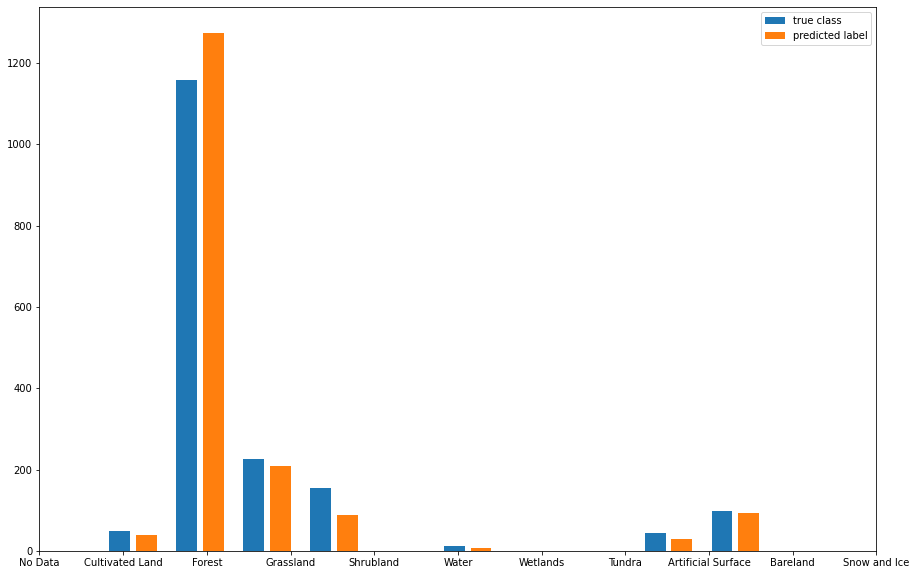

In [12]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

In [13]:
# fit the model on full unlabelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

In [14]:
# predict labels for unlabelled data
transformed_data = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(transformed_data[labels == 0]).reshape(-1)
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

In [15]:
# full data
x_train, x_val, y_train, y_val = preprocess(data, new_labels)
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (8000, 72) (8000,), validation: (2000, 72) (2000,)'

In [16]:
# fit the model on full data with new labels
cbm.fit(x_train, y_train)

In [17]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 98.52499999999999
F1-Score: [ 98.97435897  99.07289584  97.1028971   94.95934959 100.
  97.76674938  99.88623436]
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       195
           2       0.98      1.00      0.99      5454
           3       0.98      0.96      0.97      1014
           4       1.00      0.91      0.95       645
           5       1.00      1.00      1.00        47
           8       1.00      0.96      0.98       206
           9       1.00      1.00      1.00       439

    accuracy                           0.99      8000
   macro avg       0.99      0.97      0.98      8000
weighted avg       0.99      0.99      0.99      8000



Validation

Accuracy: 83.85000000000001
F1-Score: [51.85185185 93.04624073 66.13545817 37.70491803 73.68421053 62.06896552
 78.63247863]
              precision    recall  f1-score   support

           1       0.66      0.43      0.52        49
           2       0.

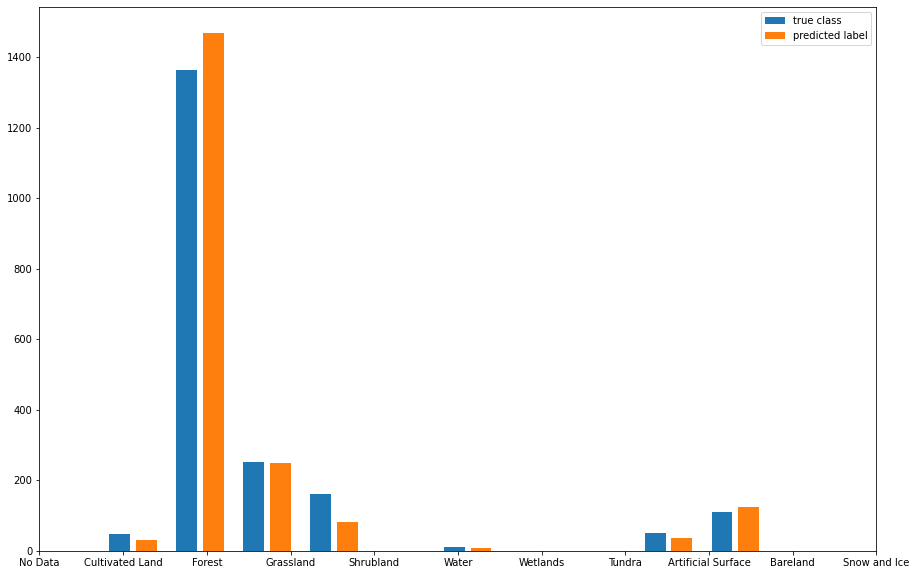

In [18]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

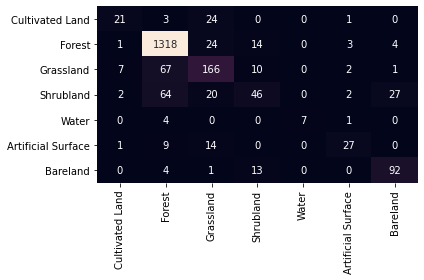

In [19]:
# confusion matrix
preds = cbm_val
preds_df = pd.DataFrame({'true':y_val, 'preds':preds})
conf_df = pd.DataFrame(confusion_matrix(preds_df['true'], preds_df['preds']), index=classes[np.unique(preds)], columns=classes[np.unique(preds)])
heatmap(conf_df, annot=True, fmt='d', cbar=False)

plt.tight_layout()
plt.show()

In [20]:
test_transformed = []
for i in range(500):
  for j in range(500):
    pixel = test[:, i, j, :].reshape((72,))
    test_transformed.append(pixel)

test_transformed = np.array(test_transformed)

pred = cbm.predict(test_transformed).reshape((500, 500))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


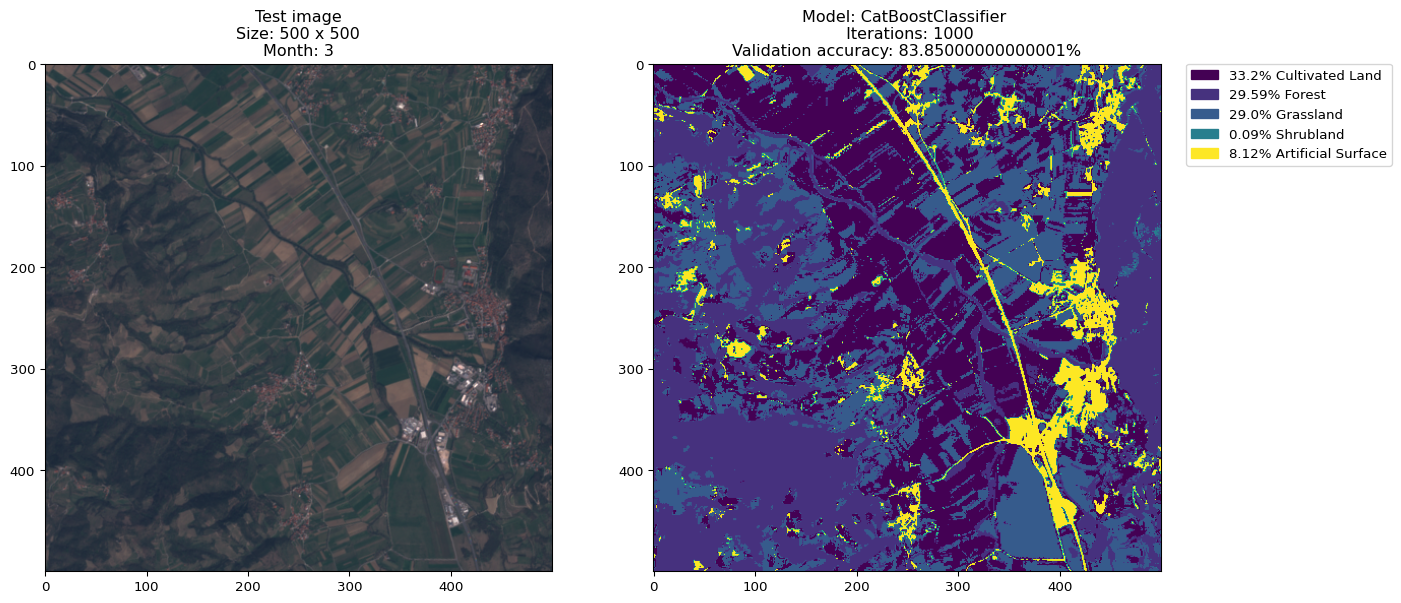

In [21]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(15,15), dpi=96)

band = 0.5 + 2.5 * (np.flip(test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')
sat.set_title(f'Test image\nSize: 500 x 500\nMonth: {month}')

im = lulc.imshow(pred)
colors = [im.cmap(im.norm(value)) for value in np.unique(pred).astype(int)]
portions = np.array([round(x, 2) for x in np.histogram(pred, bins=range(len(classes)))[0] / pred.shape[0] ** 2 * 100])[np.unique(pred).astype(int)]
patches = [Patch(color=colors[i], label=f'{portions[i]}% {classes[np.unique(pred).astype(int)[i]]}') for i in range(len(np.unique(pred).astype(int)))]

lulc.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
lulc.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

plt.show()